# Part 2: LSTM
In this section of the workshop, we will cover **Long Short Term Memory**, a complex shape of RNNs.

# The project
We will use a huge dataset (a million or so samples) of tweets that have been classified as positive or negative depending on their content. We are going to train our model to then classify input text as either positive or negative. 
The dataset has been sourced from [here](https://github.com/cblancac/SentimentAnalysisBert/tree/main/data). This kind of text classification is often referred to as **sentiment analysis**

Originally I wanted to add another Panama-related project, but I believe most of the audience does not speak Spanish... We gotta make do 😔😓

![twitter](images/twitter.webp)


The strongest point of **LSTM**s is their capacity to keep information from arbitrary elements earlier in the sequence, encoded as a *hidden state*. In this workshop, we will use a framework known as **PyTorch**.

For LSTMs, PyTorch expects every input to be 3D tensors, where the first dimension is the sequence, the second one is instances of mini-batches, and the third one indexes elements of the input.

In [1]:
#Let us start by importing some dependencies. These contained pre-defined functions and "wrappers" that will make the project a lot easier to implement.


import numpy as np # functions for linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#PyTorch related dependencies:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
#Machine Learning training can be heavy. GPU is generally preferred for it.
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


Now, it's time to load the dataset. It is currently being hosted on a platform known as *Hugging Face*, so we will first download it and then examine it. 
*Hugging Face* contains several other useful and robust datasets--feel free to examine the page to find more stuff!

In [3]:
from datasets import load_dataset

dataset = load_dataset("carblacac/twitter-sentiment-analysis")

#The dataset might be too large. In which case, we are going to trim it.
#We will use 50,000 samples for this project.
dataset["train"] = dataset["train"].select(range(6000))
dataset["validation"] = dataset["validation"].select(range(2000))
dataset["test"] = dataset["test"].select(range(1000))

Found cached dataset twitter-sentiment-analysis (/home/jespigno/.cache/huggingface/datasets/carblacac___twitter-sentiment-analysis/default/1.0.0/cd65e23e456de6a4f7264e305380b0ffe804d6f5bfd361c0ec0f68d8d1fab95b)


  0%|          | 0/3 [00:00<?, ?it/s]

*Hugging Face* provides an interface named `Datasets` for handling datasets hosted on their platform. This interface splits by default the dataset into three categories, `train`, `validation`, and `test`. Take a look:

In [4]:
print("The dataset dictionary has the following structure:")
print(dataset)
print("Let us take a look at some examples:")
for i in range(5):
    print(dataset['train'][i+20])
print("Note: 0 means the tweet is negative, 1 means the tweet is positive.")
print("The shape of the train set is:")
print(dataset['train'].shape)
print("The shape of the test set is:")
print(dataset['test'].shape)
print("The shape of the validation set is:")
print(dataset['validation'].shape)

The dataset dictionary has the following structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'feeling'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['text', 'feeling'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'feeling'],
        num_rows: 1000
    })
})
Let us take a look at some examples:
{'text': 'Twitter is useful in that it reminds people what they forgot to ask me about on a given day. It is also excellent for inspiration', 'feeling': 1}
{'text': 'Hoping I at least have fun 2nite.  Today was 1 horrible way 2 start off a birthday', 'feeling': 0}
{'text': "@kirsty_gilfo yup! That's the one  Mmm....yum cha! Have lots of dumplings for me", 'feeling': 1}
{'text': 'Italian Shaved on the mall is D-licious and all over me!!!  and my printer...  But it is D-Licious!', 'feeling': 0}
{'text': "Mum's off to bed... Nip/tuck time noow", 'feeling': 1}
Note: 0 means the tweet is negative, 1 means the tweet is

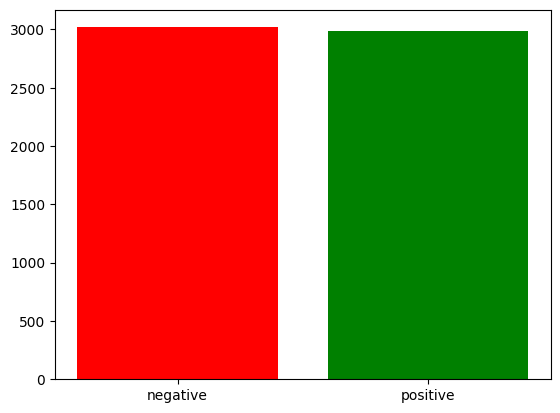

In [5]:
#Let us take a look at the distribution of the data
#only consider the feeling
dd = pd.Series(dataset['train']['feeling']).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
colors = ['red', 'green']
plt.bar(np.array(['negative','positive']), dd.values, color=colors)
plt.show()

## Preprocessing and Tokenisation
The dataset comes from twitter, so there are a lot of random characters in the text (e.g hashtags). Furthermore, there might be a lot of "stop words" in the text. Stop words are words that do not give any information regarding the text, such as *a, the, is, are*. We want to delete them from the text so that they make calculations easier. 
This process is known as **preprocessing**.
Afterwards, we are going to **tokenise** the dataset. This means assigning each unique word to a token that allows for easier computation

In [6]:
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    #make all letters lowercase
    s = s.lower()
    return s


import nltk
nltk.download('stopwords')
def tokenise_dataset(dataset):
    word_list = []
    stop_words = set(stopwords.words('english'))
    for split in ['train','test','validation']:
        for i in tqdm(range(dataset[split].shape[0])):
            for word in dataset[split]['text'][i].split():
                word = preprocess_string(word)
                if word not in stop_words and word != '':
                    word_list.append(word)
    corpus = Counter(word_list)
    #sort the words by frequency
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:10000]
    #create a dictionary
    word_dict = {w:i+2 for i,w in enumerate(corpus_)}
    dataset_token = {'train':{},'test':{},'validation':{}}

    #tokenise
    for split in ['train','test','validation']:
        final_tweets = []
        for tweet in tqdm(range(dataset[split].shape[0])):
            final_tweets.append([word_dict[preprocess_string(word)] for word in dataset[split]['text'][tweet].split() if preprocess_string(word) in word_dict.keys()])
        dataset_token[split]['text'] = np.array(final_tweets,dtype=object)
        dataset_token[split]['feeling'] = np.array(dataset[split]['feeling'])
    return dataset_token,word_dict


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jespigno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
dataset_token, word_dict = tokenise_dataset(dataset)
print("The length of the word dictionary is:", len(word_dict))

  0%|          | 0/6000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:02<00:00, 679.23it/s]

The length of the word dictionary is: 10000


In [9]:
#At this point, the dataset has been tokenised. Let us examine one example to see what this looks like.
print("The first tweet in the training set is:")
print(dataset['train']['text'][0])
print("After tokenisation, it looks like this:")
print(dataset_token['train']['text'][0])
print("If we were to convert from tokens back to words, we would get:")
print(' '.join([list(word_dict.keys())[i-2] for i in dataset_token['train']['text'][0]]))

The first tweet in the training set is:
@fa6ami86 so happy that salman won.  btw the 14sec clip is truely a teaser
After tokenisation, it looks like this:
[3120, 57, 4877, 386, 1888, 4878, 3121, 4879]
If we were to convert from tokens back to words, we would get:
faami happy salman btw sec clip truely teaser


The next step for us is to analyse the length of each tweet. LSTMs work best when all the inputs are of the **same size**. In order for us to achieve this, we need to analyse what is the longest tweet in our dataset, and make all of the other training samples be the same length.
We can make this happen with **padding**. Padding will add zeroes to all the sequences shorter than the longest ones so that effectively they all have the same size. When computing, the network will ignore all the zero values at the end, so this will not have an impact on the accuracy of predictions

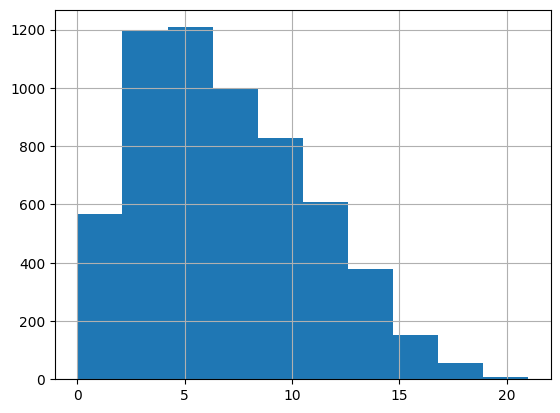

count    6000.000000
mean        7.102000
std         3.776326
min         0.000000
25%         4.000000
50%         7.000000
75%        10.000000
max        21.000000
dtype: float64

In [10]:
total_lenght = [len(i) for i in dataset_token['train']['text']]
pd.Series(total_lenght).hist()
plt.show()
pd.Series(total_lenght).describe()

Even though the mean tweet length is 7, there are some remarkably long tweets (up to 21 tokens!). We can either manually inspect these elements in our dataset and determine whether or not they are needed OR we can just pad everything to that maximum value.

In [11]:
def padding_(data, max_length):
    features = np.zeros((len(data), max_length),dtype=int)
    for i, row in enumerate(data):
        if len(row) != 0:
            features[i, -len(row):] = np.array(row)[:max_length]
    return features

#Let us apply the function to the dataset
max_length = 21
dataset_token_pad = {'train':{},'test':{},'validation':{}}
for split in ['train','test','validation']:
    dataset_token_pad[split]['text'] = padding_(dataset_token[split]['text'], max_length)
    dataset_token_pad[split]['feeling'] = dataset_token[split]['feeling']

The next step is to **batch** the data. This allows us to feed the data in packages to the model, which makes the training process more efficient.

In [12]:
training_data = TensorDataset(torch.from_numpy(dataset_token_pad['train']['text']), torch.from_numpy(dataset_token_pad['train']['feeling']))
testing_data = TensorDataset(torch.from_numpy(dataset_token_pad['test']['text']), torch.from_numpy(dataset_token_pad['test']['feeling']))
validation_data = TensorDataset(torch.from_numpy(dataset_token_pad['validation']['text']), torch.from_numpy(dataset_token_pad['validation']['feeling']))

#dataloaders
batch_size = 50
train_loader = DataLoader(training_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(testing_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(validation_data, shuffle=True, batch_size=batch_size)
#shuffle allows us to make sure the model does not learn the order of the data

Let us look at a single batch of data

In [13]:
iterr = iter(train_loader)
sample_x, sample_y = next(iterr)
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 21])
Sample input: 
 tensor([[   0,    0,    0,  ..., 1006,  257, 8417],
        [   0,    0,    0,  ...,    3, 1019, 2551],
        [   0,    0,    0,  ...,    2,   92,  105],
        ...,
        [   0,    0,    0,  ...,  288, 8286,  389],
        [   0,    0,    0,  ...,   26,  569,  253],
        [   0,    0,    0,  ...,   14,   45,  225]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 1])


Remember, the input is of size [50,21] because there are 50 sentences with 21 entries each. When it comes to the label, 0 is negative and 1 is positive. 

The time has arrived, time to
## create the model!

In [14]:
class SentimentRNN(nn.Module):
    #every class in PyTorch should have a __init__ function, which is used to define the parameters of the model.
    #Here, the output dimension and the hidden dimension represent the number of nodes in the output layer and the hidden layer, respectively.
    
    def __init__(self,no_layers,vocab_size, output_dim, hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    #The forward function is used to define the forward pass of the model. This is where the input tensor is passed through the layers in the model.
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
    #The init_hidden function is used to initialise the hidden state of the LSTM. This is used to clear out the hidden state at the beginning of each epoch.
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

The model has been defined. Now, we are going to set some of its parameters:

In [15]:
number_of_layers = 2
vocabulary_size = len(word_dict)+2
output_dimension = 1 #either positive or negative
hidden_dimension = 256
embedding_dimension = 400

model = SentimentRNN(number_of_layers,vocabulary_size,output_dimension,hidden_dimension,embedding_dimension)

#move to gpu if available
model.to(device)
print("Take a look at what you are working with right now:")
print(model)

Take a look at what you are working with right now:
SentimentRNN(
  (embedding): Embedding(10002, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


## Training
It is time for us to start the training process. 
Training is usually pretty standard; on each epoch, the model will compute the forward pass and then perform the back propagation after calculating the loss. The key aspect of training are **hyperparameters**, which are specific values you can adjust to improve the performance of your training. 
Let us have a quick intro of some of them:
1. Learning rate: Determines the step size at each iteration; basically how much the model will change in response to the estimated error.
2. Criterion: It is the "rule" for stopping the algorithm you are using. Sometimes finding the real minimum might take extremely long; a criterion might prevent this from happening by allowing the algorithm to settle at a different optimum level.
3. Optimizer: It is a function or algorithm that adjusts the attributes of the neural network (e.g. weights and learning rate) after each iteration
4. Clip value: Maximum value we allow the gradients to get. Gradients, which are calculated during backward pass, encapsulate information collected from the data. Sometimes they can contain long-range dependencies in multidimensional data, so they can "explode", grow very large and prevent the model from converging. Gradient clipping prevents this.
5. Epochs: One complete pass of the training dataset through the algorithm.

In [16]:
#Ok now that we are familiar with these hyperparameters, let us define them:
learning_rate = 0.001
criterion = nn.BCELoss() #Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #Adam Optimiser
clip_value = 5 #for gradient clipping
epochs = 20

#accuracy function
def acc(pred,label):
    pred = torch.round(pred.squeeze()) #rounds the output to 0/1
    return torch.sum(pred == label.squeeze()).item() #convert into numpy array

### Training Function

In [17]:
valid_loss_min = np.Inf
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    
    #Make the model ready for training. If the model is not in this mode, the model will not update the weights.
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.6345229695240656 val_loss : 0.5848905466496944
train_accuracy : 62.21666666666666 val_accuracy : 68.75
Validation loss decreased (inf --> 0.584891).  Saving model ...
Epoch 2
train_loss : 0.4350559792170922 val_loss : 0.5774421162903309
train_accuracy : 80.08333333333333 val_accuracy : 70.85000000000001
Validation loss decreased (0.584891 --> 0.577442).  Saving model ...
Epoch 3
train_loss : 0.21418051272630692 val_loss : 0.7696377709507942
train_accuracy : 91.5 val_accuracy : 68.89999999999999
Epoch 4
train_loss : 0.08171276380307972 val_loss : 1.142621460556984
train_accuracy : 97.13333333333334 val_accuracy : 68.4
Epoch 5
train_loss : 0.03386547132783259 val_loss : 1.398746582865715
train_accuracy : 98.65 val_accuracy : 68.55
Epoch 6
train_loss : 0.020592070669711877 val_loss : 1.5136861816048621
train_accuracy : 99.25 val_accuracy : 69.85
Epoch 7
train_loss : 0.006015039164109718 val_loss : 1.9000390857458114
train_accuracy : 99.75 val_accuracy : 69.55
Epoch 

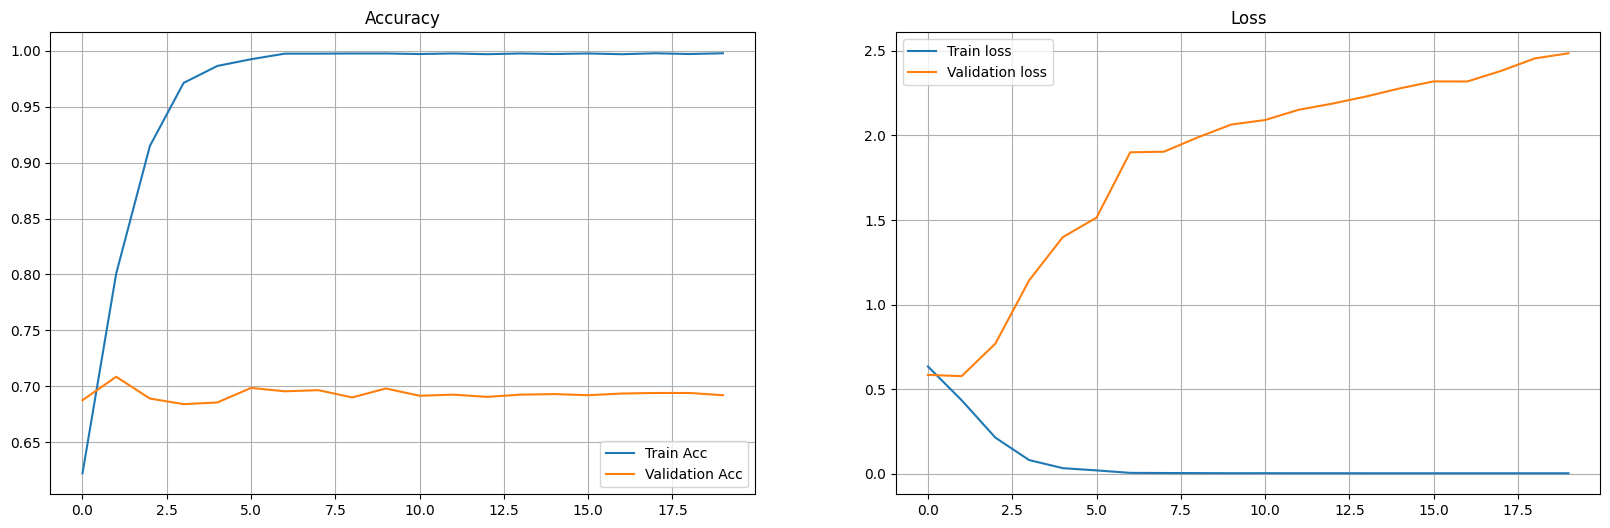

In [18]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

Now, it is time for us to perform **inference**, the process of having your model predict labels from data it has never seen before.

In [21]:
def predict_text(text):
        word_seq = np.array([word_dict[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in word_dict.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())
    
index = 30
print(dataset['train']['text'][index])
print('='*70)
actual_sentiment = "positive" if dataset['train']['feeling'][index] == 1 else "negative"
print(f'Actual sentiment is  : {actual_sentiment}')
print('='*70)
pro = predict_text(dataset['train']['text'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

@Junderstated lls ain't that the truth
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.9999957084655762
